# Home Assignment 2

### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from threading import Thread
import pandas as pd

### Load Data
Load images as vectors

In [2]:
## Sample size
train = 900
test = 750

## Dimensions can be changed and images will be rescaled in the next section
d = 28*28
size = (28,28)
    
def load_train_data(ntrain=300):
    A_train = np.array([cv2.imread("data2/train/A/A_train_%d.png" % i, 0) for i in range(1, ntrain+1)])
    B_train = np.array([cv2.imread("data2/train/B/B_train_%d.png" % i, 0) for i in range(1, ntrain+1)])
    C_train = np.array([cv2.imread("data2/train/C/C_train_%d.png" % i, 0) for i in range(1, ntrain+1)])
    Y = np.concatenate((np.ones(ntrain), -1*np.ones(2*ntrain)))
    X = np.concatenate((A_train, B_train, C_train))
    
    return X, Y

def load_test_data(ntest=250):
    A_test = np.array([cv2.imread("data2/test/A/A_test_%d.png" % i, 0) for i in range(1, ntest+1)])
    B_test = np.array([cv2.imread("data2/test/B/B_test_%d.png" % i, 0) for i in range(1, ntest+1)])
    C_test = np.array([cv2.imread("data2/test/C/C_test_%d.png" % i, 0) for i in range(1, ntest+1)])
    Y = np.concatenate((np.ones(ntest), -1*np.ones(2*ntest)))
    X =  np.concatenate((A_test, B_test, C_test))
    return X, Y


## Load train and test data
X_train, Y_train = load_train_data()
X_test, Y_test = load_test_data()

X_train = np.array([x.flatten() for x in X_train])
X_test = np.array([x.flatten() for x in X_test])

X_all = np.concatenate((X_train, X_test))
Y_all = np.concatenate((Y_train, Y_test))

## Normalize features
X_train = np.apply_along_axis(lambda c : (c - np.mean(c))/np.std(c), 0, X_train)
X_test = np.apply_along_axis(lambda c : (c - np.mean(c))/np.std(c), 0, X_all)[train:]
X_all_norm = np.apply_along_axis(lambda c : (c - np.mean(c))/np.std(c), 0, X_all)

# Exercise 1

# Regularization of logistic loss


#### Logistic loss with L1 norm regularization
$\ell(\beta) = \frac{1}{n} \sum_{i = 1}^n \log (1 + e^{-\beta^\top X_iY_i}) + \lambda ||\beta||_1$ <br/>
$\nabla \ell(\beta) = \frac{1}{n} \sum_{i = 1}^n \frac{-X_iY_i e^{-\beta^\top X_iY_i}}{1 + e^{-\beta^\top X_iY_i}} + g$  where $g \in \{z | z_j \in [-1,1]$ and forall $1 \leq j \leq d,  z_j = sign(\beta_j)$ if $\beta_j \neq 0, \}$

#### Logistic loss with L2 norm regularization
$\ell(\beta) = \frac{1}{n} \sum_{i = 1}^n \log (1 + e^{-\beta^\top X_iY_i}) + \lambda ||\beta||_2$ <br/>
$\nabla \ell(\beta) = \frac{1}{n} \sum_{i = 1}^n \frac{-X_iY_i e^{-\beta^\top X_iY_i}}{1 + e^{-\beta^\top X_iY_i}} + 2\lambda\beta$


In [3]:
def logistic_l1(theta, x, y, lambdar):
    ## Logistic gradient
    xtheta = np.dot(x, theta)
    expo = np.exp(-xtheta*y)
    grad = (-1/len(y))*np.dot(x.T, y*expo/(1+expo))
    
    # Subgradient
    subgrad = np.array([np.sign(x) if x != 0 else sign(np.random.randint(0, 2) - 0.5) for x in theta])
    return grad + lambdar*subgrad

def logistic_l2(theta, x, y, lambdar):
    ## Logistic gradient
    xtheta = np.dot(x, theta)
    expo = np.exp(-xtheta*y)

    grad = (-1/len(y))*np.dot(x.T, y*expo/(1+expo))
    
    return grad + lambdar*2*theta

def loss01(theta, x, y):
    pred = np.sign(np.dot(x, theta))
    loss = (1/len(y))*np.sum([0 if pred[i] == y[i] else 1 for i in range(len(y))])
    
    return loss


### Gradient Descent

In [4]:
def gd(X, Y, theta0, lr, nb_iter, objective, lambdar):
    theta = theta0
    for i in range(nb_iter):
        ## Get objective gradient
        grad = objective(theta, X, Y, lambdar)
        ## Update
        theta = theta - lr*grad
    return theta


### K-Fold cross validation

In [5]:
def k_fold(x, y, nset, lambdar, lr, theta0, iters_gd, objective):
        
        n = len(y)
        chunk = int(np.floor(n/nset))
        
        assert np.floor(n/nset) == chunk
        
        ## Load data
        random_indexes = np.array(range(n))
        np.random.shuffle(random_indexes)
        
        x = np.array([x[i] for i in random_indexes])
        y = np.array([y[i] for i in random_indexes])
        
        loss_train = 0
        loss_val = 0
        thetas = np.zeros(len(theta0))
        
        xsets = np.array([x[i:(i+chunk)] for i in range(0, n-1, chunk)])
        ysets = np.array([y[i:(i+chunk)] for i in range(0, n-1, chunk)])
        
        ## Compute loss for each set as test data and the rest as training
        for s in range(nset):
            
            ## Sample data
            xtest = xsets[s]
            ytest = ysets[s]
            
            xtrain = np.array([np.array(xsets[a]).flatten() for a in range(nset) if a != s]).reshape(-1, xsets.shape[-1])
            ytrain = np.array([ysets[a] for a in range(nset) if a != s]).flatten()

            theta = gd(xtrain, ytrain, theta0, lr, iters_gd, objective, lambdar)
            
            thetas += theta
            
        return thetas/nset
    

def find_lambda(x, y, test_x, test_y, lambda_values, objective, lr=0.1, theta0=1e-3*np.ones(d), iters_gd=20, nset=5):
    
    thetas = [0 for i in lambda_values]
    
    ## For all values of lambda compute the loss using K-fold algorithm with K = 5
    def compute_loss(x, y, nset, index, lambdar, lr, theta0, iters_gd, objective):
        theta = k_fold(x, y, nset, lambdar, lr, theta0, iters_gd, objective)
        thetas[index] = theta
    
    ## Compute each lambda in different thread
    threads = [Thread(target=compute_loss, 
                      args=(x, y, nset, i, lambda_values[i], lr, theta0, iters_gd, objective)) 
               for i in range(len(lambda_values))]
    
    for th in threads:
        th.start()
        
    for th in threads:
        th.join()
    
    test = [loss01(t, test_x, test_y) for t in thetas]
    train = [loss01(t, x, y) for t in thetas]
    
    return lambda_values[np.argmin(test)], train, test, thetas

In [6]:
## Parameters
lambda_values =  list(np.linspace(0,6,4))

lambda_opt_l1, ltrain_l1, ltest_l1, thetas_l1 = find_lambda(X_train, 
                                                            Y_train,
                                                            X_test, 
                                                            Y_test,
                                                            lambda_values,
                                                            objective = logistic_l1)

lambda_opt_l2, ltrain_l2, ltest_l2, thetas_l2 = find_lambda(X_train, 
                                                            Y_train,
                                                            X_test, 
                                                            Y_test,
                                                            lambda_values,
                                                            objective = logistic_l2)

### Training and test errors (0-1 loss)

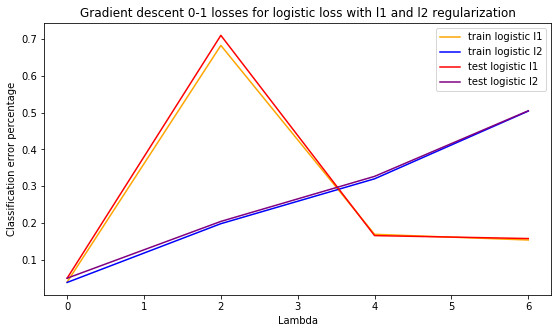

In [7]:
## Training and test error plots for GD with logitic loss l1 and l2 regularization
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)

### Plot training losses
plt.plot(lambda_values, ltrain_l1, color = 'orange', label='train logistic l1')
plt.plot(lambda_values, ltrain_l2, color = 'blue', label='train logistic l2')

### Plot test losses
plt.plot(lambda_values, ltest_l1, color = 'red', label='test logistic l1')
plt.plot(lambda_values, ltest_l2, color = 'purple', label='test logistic l2')


plt.legend()
plt.ylabel('Classification error percentage')
plt.xlabel('Lambda')
plt.title('Gradient descent 0-1 losses for logistic loss with l1 and l2 regularization')

plt.show()

### Estimators plots 
Plot of averaged K-fold cross validation estimators $\overline \theta_\lambda$ for different values of $\lambda$ with $K=5$

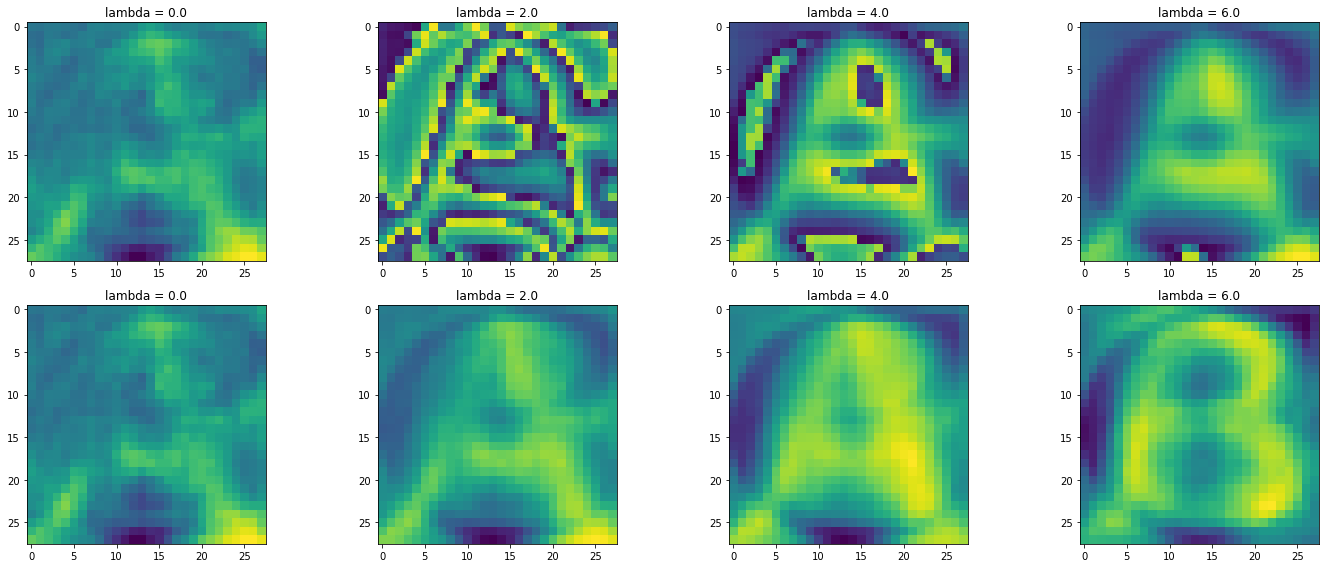

In [29]:
## Estimators plots for logistic loss with l1 and l2 regularization using gradient descent averaged from K-fold cross validation
plt.figure(figsize=(20, 8))

nrows = len(lambda_values)

for i in range(nrows):
    plt.subplot(2, nrows, i+1)
    plt.imshow(thetas_l1[i].reshape(size))
    plt.title("lambda = " + str(lambda_values[i]))

for i in range(nrows):
    plt.subplot(2, nrows, nrows + i + 1)
    plt.imshow(thetas_l2[i].reshape(size))
    plt.title("lambda = " + str(lambda_values[i]))

plt.tight_layout()

# Exercise 2

In [6]:
def log_likelihood(x, y, mu1, mu2, sigmainv, pi, lambd=0):
    n = len(y)
    sigmainv = sigmainv + lambd*np.identity(n)
    beta0 = 0.5*np.log((1-pi)/pi)*(mu1.T @ sigmainv @ mu1 - mu2.T @ sigmainv @ mu2)
    beta1 = np.log((1-pi)/pi)*(mu2 - mu1).T @ sigmainv
    likelihood = np.sum(np.log([1 + np.exp(y[i]*(-beta0 - beta1.T @ x[i])) for i in n]))
    return likelihood

# Exercise 3

# PCA

In [10]:
def pca(x, k=None):
    
    ## Default value of k
    if k is None:
        k = x.shape[1]
    
    ## Center observations
    means = np.mean(x, axis=1)
    x_c = (x.T - means).T

    ## Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(x_c.T @ x_c)
    
    # Drop imaginary part (numerical errors since covariance matrix is symetric)
    eigen = sorted(list(zip(np.real(eigenvalues), np.real(eigenvectors).T)), key=lambda x: x[0], reverse=True)
    
    ## Compute orthonormal projection matrix by stacking eigenvectors normalized
    p = np.vstack(tuple([i[1] for i in eigen])).T
    
    proj = x_c @ p[:, :k]
    
    return proj, p[:, :k]

In [11]:
def explained_var(x):
    var = np.apply_along_axis(lambda c : np.var(c), 0, x)
    total_var = np.sum(var)
    return var/total_var

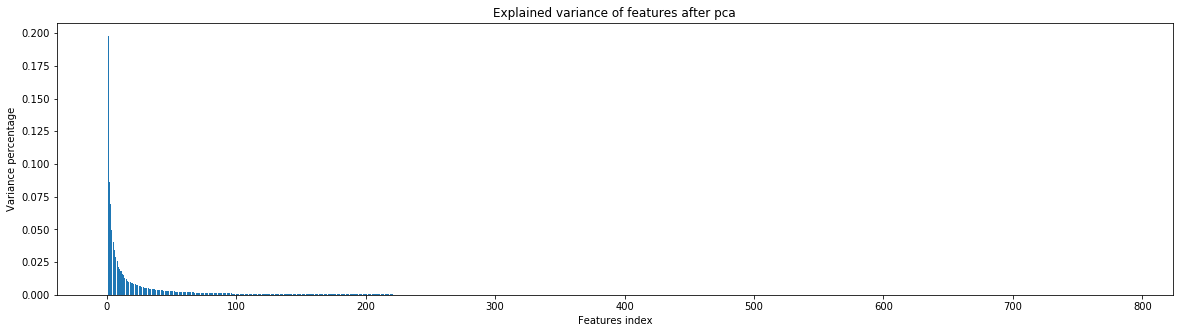

In [32]:
############# EXPLAINED VARIANCE
after_pca, p = pca(X_all_norm)

plt.figure(figsize=(20, 5))
plt.bar(list(range(1, after_pca.shape[1]+1)), height=explained_var(after_pca))

plt.ylabel('Variance percentage')
plt.xlabel('Features index')
plt.title('Explained variance of features after pca')

plt.show()

# K-means

In [81]:
def stop_cond(prev_centers, centers, max_iter, niter):
    if niter > max_iter:
        return True
    else:
        return np.array_equal(prev_centers, centers)

In [82]:
def k_means(x, max_iter=100, nc=3):
    
    n = x.shape[0]
    centers = np.array([x[i] for i in random.sample(range(n), nc)])
    family = [[] for i in range(nc)]
    labels = np.array([None for i in range(n)])
    
    iteration = 0
    previous_centers = None
    
    while not stop_cond(previous_centers, centers, max_iter, iteration):    
        previous_centers = centers
        
        ## Compute labels
        for i in range(n):
            label = np.argmin([np.linalg.norm(x[i] - j) for j in centers])
            family[label].append(x[i])
            labels[i] = label
    
        ## Update centers
        centers = np.array([np.mean(np.array(j), axis=0) for j in family])

        ## Reset families
        family = [[] for i in range(nc)]
    
        iteration += 1
        
    return np.array(labels), np.array(centers)

In [83]:
def classify_kmeans(x, ninit=10, max_iter=100, nc=3):
    l, centers = k_means(x, max_iter, nc)

    for i in range(2, ninit+1):
        l, c = k_means(x, max_iter, nc)
        centers = (1/i)*(c + (i-1)*centers)
        
    labels = [np.argmin([np.linalg.norm(i - j) for j in centers]) for i in x]
    
    return labels, centers

In [84]:
## PCA
pca_x, p = pca(X_all_norm, k=2)

In [91]:
## K_means
labels, centers = classify_kmeans(X_all_norm, max_iter = 100)

In [92]:
## Projection onto principal components
pca_centers = centers @ p

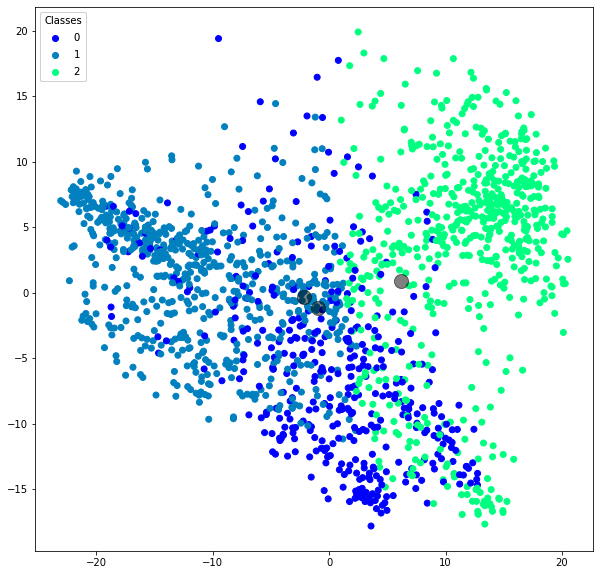

In [93]:
## Plot predictions
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(pca_x[:, 0], pca_x[:, 1], c=labels, cmap='winter')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [94]:
## Real labels (find A, B and C according to most frequent label in cluster)
class_train = int(train/3)
class_test = int(test/3)

A = np.argmax(np.bincount(labels[:class_train] + labels[3*class_train:(3*class_train + class_test)]))
B = np.argmax(np.bincount(labels[class_train:2*class_train] + labels[(3*class_train + class_test):(3*class_train + 2*class_test)]))
C = np.argmax(np.bincount(labels[2*class_train:3*class_train] + labels[(3*class_train + 2*class_test):(3*class_train + 3*class_test)]))

ylabel = [A for i in range(class_train)] + [B for i in range(class_train)] + [C for i in range(class_train)] + [A for i in range(class_test)] + [B for i in range(class_test)] + [C for i in range(class_test)]

In [95]:
## GET LABELS
print("A : " + str(A))
print("B : " + str(B))
print("C : " + str(C))

A : 1
B : 0
C : 2


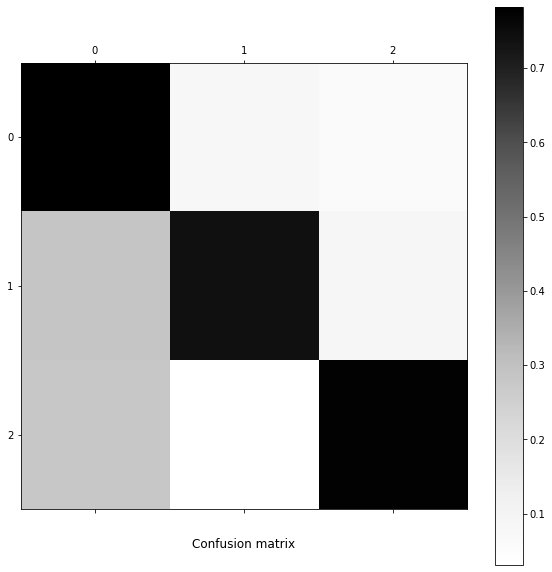

In [97]:
## CONFUSION MATRIX
m = pd.crosstab(pd.Series(labels, name='Predictions'),
                pd.Series(ylabel, name='Actual'))
m_norm = m / m.sum(axis=1)

plt.figure(figsize=(10, 10))
plt.matshow(m_norm, cmap=plt.get_cmap("Greys"), fignum=1)
plt.title('Confusion matrix', y=-0.1)
plt.colorbar()
tick_marks = np.arange(m.shape[1])

plt.show()